# **Predicting Job Change using Python**

This notebook covers how to use Python machine learning libraries to construct a predictive model from HR data. The dataset is from the Kaggle task "HR Analytics: Job Change of Data Scientists" provided by user Möbius (https://www.kaggle.com/arashnic/hr-analytics-job-change-of-data-scientists)

First, we'll take a look at the two datasets. We'll load up some useful libraries, and create dataframes from the .csv files provided. We'll also set a RandomState for reproducibility.

In [1]:
import numpy as np
import pandas as pd

rng = np.random.RandomState(123)
train = pd.read_csv("../input/hr-analytics-job-change-of-data-scientists/aug_train.csv")
test = pd.read_csv("../input/hr-analytics-job-change-of-data-scientists/aug_test.csv")

train.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [2]:
test.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,32403,city_41,0.827,Male,Has relevent experience,Full time course,Graduate,STEM,9,<10,NaN,1,21
1,9858,city_103,0.920,Female,Has relevent experience,no_enrollment,Graduate,STEM,5,NaN,Pvt Ltd,1,98
2,31806,city_21,0.624,Male,No relevent experience,no_enrollment,High School,NaN,<1,NaN,Pvt Ltd,never,15
3,27385,city_13,0.827,Male,Has relevent experience,no_enrollment,Masters,STEM,11,10/49,Pvt Ltd,1,39
4,27724,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,10000+,Pvt Ltd,>4,72


In [3]:
train.loc[:,train.dtypes == "object"] = train.loc[:,train.dtypes == "object"].astype("category")
train['target'] = train['target'].astype("category")

train.select_dtypes("category").describe()

,city,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,target
count,19158,14650,19158,18772,18698,16345,19093,13220,13018,18735,19158.0
unique,123,3,2,3,5,6,22,8,6,6,2.0
top,city_103,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,1,0.0
freq,4355,13221,13792,13817,11598,14492,3286,3083,9817,8040,14381.0


In [4]:
train.select_dtypes({"int64","float64"}).drop(columns = "enrollee_id").describe()

,city_development_index,training_hours
count,19158.000000,19158.000000
mean,0.828848,65.366896
std,0.123362,60.058462
min,0.448000,1.000000
25%,0.740000,23.000000
50%,0.903000,47.000000
75%,0.920000,88.000000
max,0.949000,336.000000


In [5]:
target_counts = pd.DataFrame({'target': train['target']})
print("Percent of training set with target = 0: %.3f" % (len(target_counts[target_counts['target'] == 0]) / len(target_counts)) )
print("Percent of training set with target = 1: %.3f" % (len(target_counts[target_counts['target'] == 1]) / len(target_counts)) )

Percent of training set with target = 0: 0.751
Percent of training set with target = 1: 0.249


In [6]:
pd.DataFrame({'dtype': train.dtypes,
              'null_count': train.isna().sum()})

,dtype,null_count
enrollee_id,int64,0
city,category,0
city_development_index,float64,0
gender,category,4508
relevent_experience,category,0
enrolled_university,category,386
education_level,category,460
major_discipline,category,2813
experience,category,65
company_size,category,5938


As the documentation mentioned, the attributes of the data may pose some issues while modeling, such as:

1. Imbalanced data set
2. High cardinality (uniqueness) in some features
3. Missing data

Let's explore our training set further and do some basic summary/visualization to explore the data.

# Exploratory Data Analysis

Let's begin by looking at the distribution of our categorical variables.

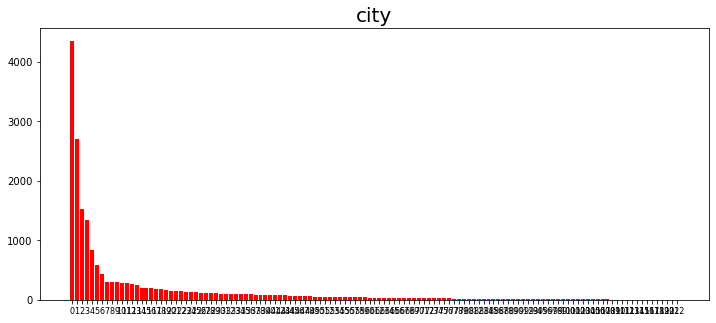

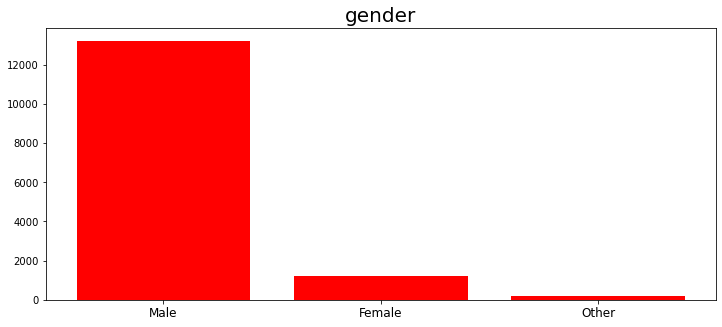

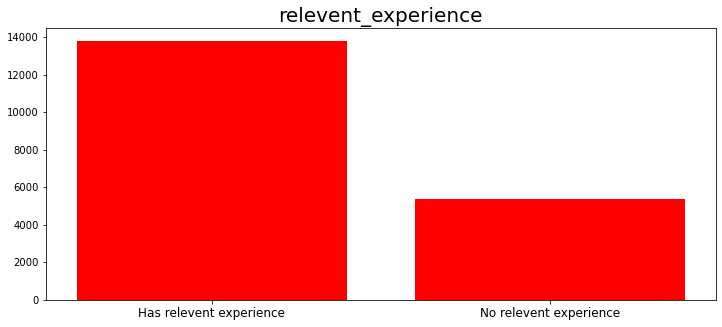

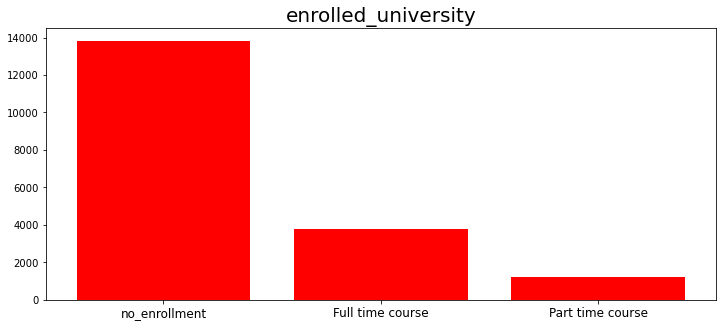

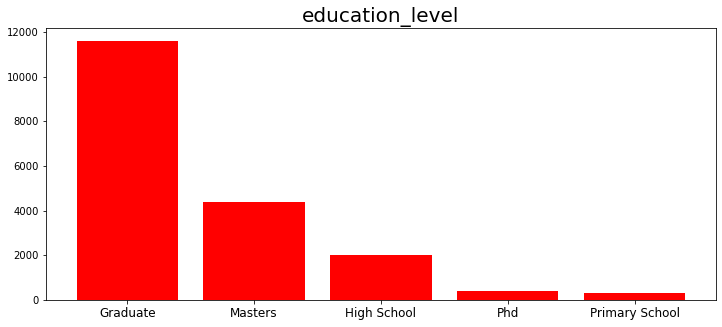

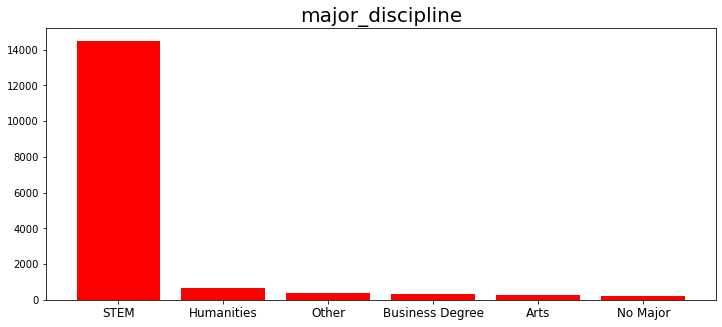

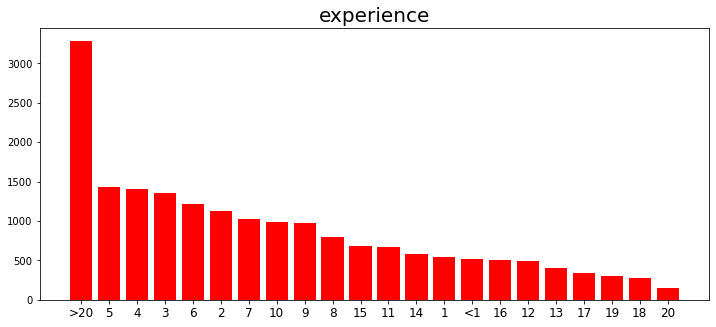

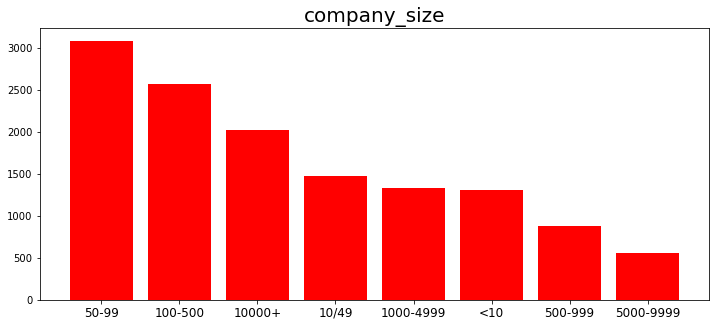

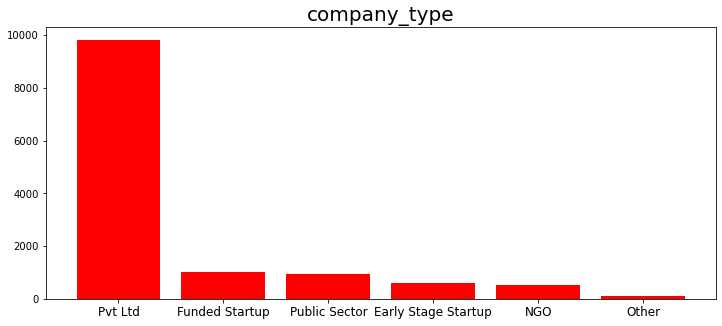

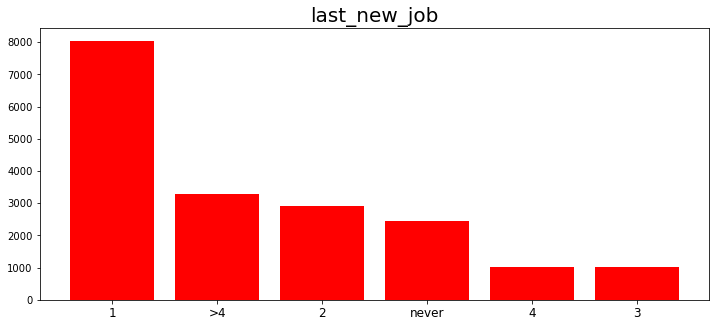

In [7]:
import matplotlib.pyplot as plt

cat_list = train.select_dtypes("category").columns.drop('target').tolist()
for i in cat_list:
    val_counts = pd.DataFrame(train[i].value_counts())
    plt.figure(figsize = (12, 5))
    plt.title(i, fontsize = 20)
    if i == 'city':
        plt.bar(range(len(val_counts)), val_counts[i], color="r", align="center")
        plt.xticks(range(len(val_counts)), fontsize = 8)
    else:
        plt.bar(val_counts.index, val_counts[i], color="r", align="center")
        plt.xticks(val_counts.index, fontsize = 12)
    plt.show()

Let's also take a look at the relationship between each categorical variable and the outcome. The y-axis indicates a count. In the plots below, <span style="color:blue"> **blue** </span> indicates a person is not seeking a new job, whereas <span style="color:red">**red**</span> indicates that they are.

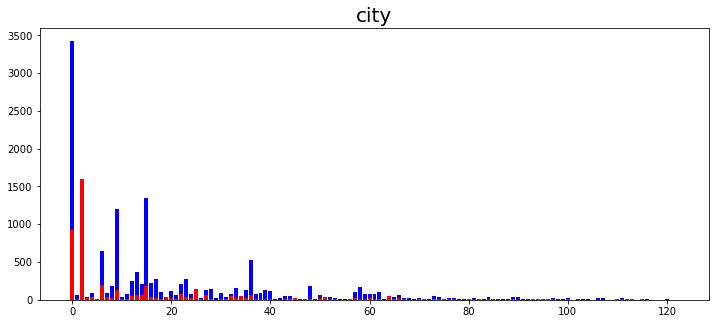

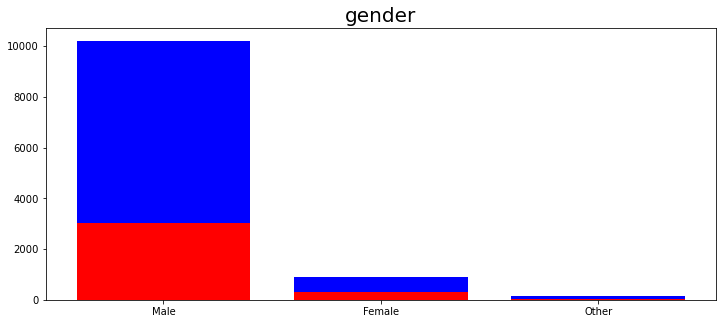

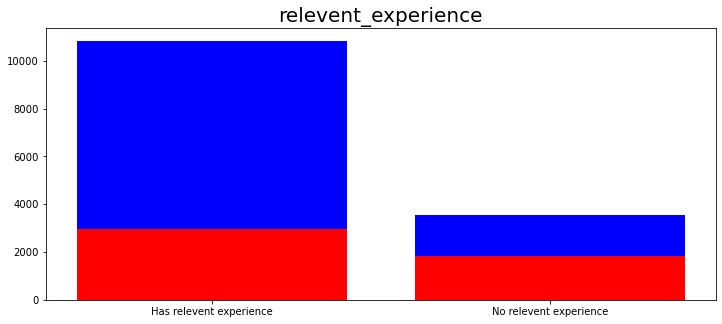

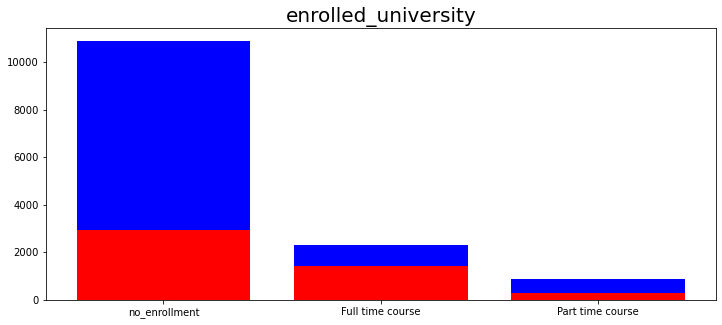

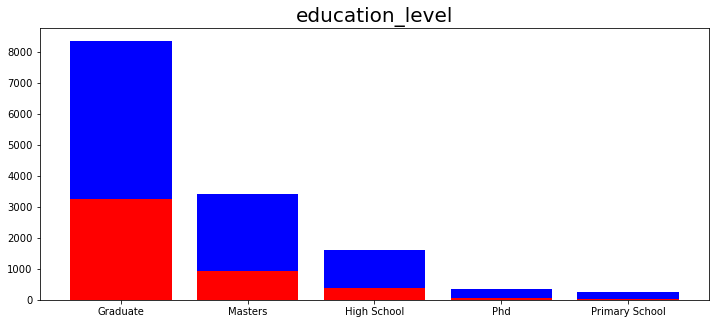

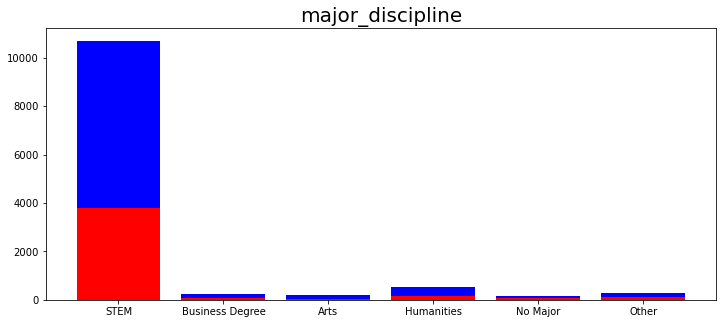

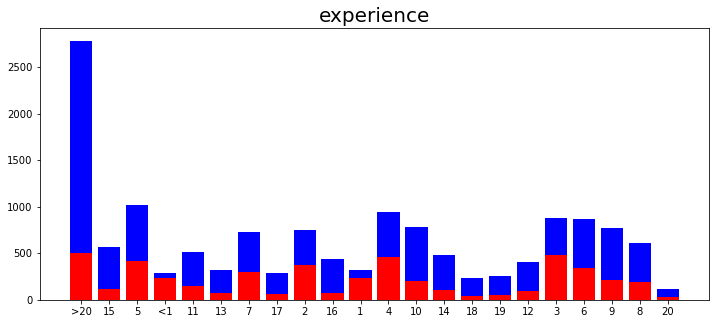

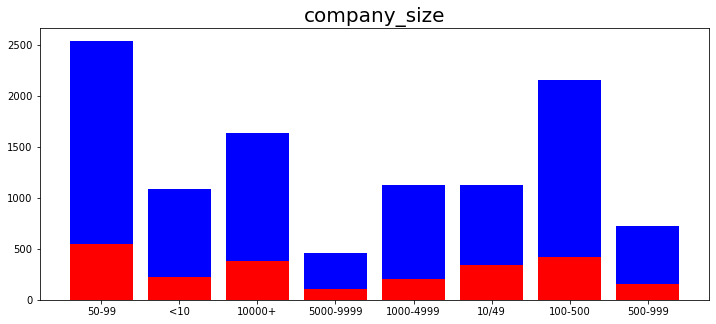

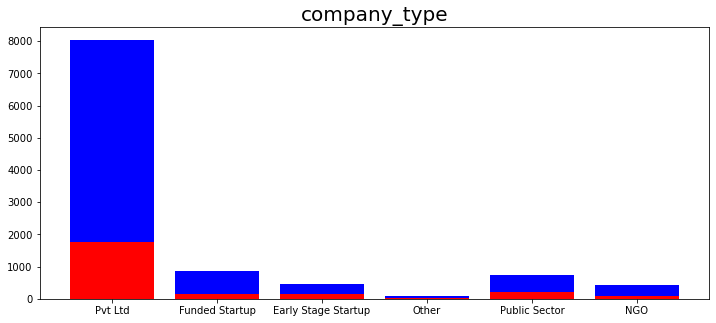

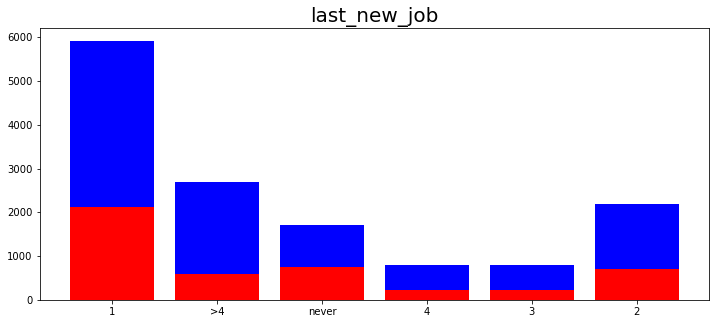

In [8]:
for i in cat_list:
    unique_vals = pd.Series(train[i].unique())
    plot_df = pd.DataFrame()
    plt.figure(figsize = (12, 5))
    plt.title(i, fontsize = 20)
    for j in unique_vals:
        width = .35
        unique_df = pd.DataFrame(train[train[i] == j])
        t0 = len(unique_df[unique_df['target'] == 0])
        t1 = len(unique_df[unique_df['target'] == 1])
        new = pd.DataFrame({'j' : j, 't0' : t0, 't1' : t1}, index = [0])
        plot_df = plot_df.append(new)
    plot_df = plot_df.reset_index(drop = True)
    plot_df = plot_df.dropna(axis = 0)
    if i == 'city':
        plt.bar(range(len(unique_vals)), plot_df['t0'], color="b", align="center")
        plt.bar(range(len(unique_vals)), plot_df['t1'], color="r", align="center")
    else:
        plt.bar(plot_df['j'], plot_df['t0'], color="b", align="center")
        plt.bar(plot_df['j'], plot_df['t1'], color="r", align="center")
    plt.show()

It seems that within each categorical variable, the levels of the variable differ in terms of the proportion of new job seekers versus those who want to remain at their current job. Let's use a chi-squared test to further examine the relationship between each feature and the target variable. The test examines how different the observed counts than what is expected, under the assumption that they are independent.

In [9]:
from scipy.stats import chi2_contingency

for i in cat_list:
    table = pd.crosstab(train[i], train['target'])
    chi2_stat, p, dof, expected = chi2_contingency(table)
    print("Variable [",i,"] has a chi2 statistic of [%.2f] with a p-value of [%.3f]" % (chi2_stat, p))

Variable [ city ] has a chi2 statistic of [2998.78] with a p-value of [0.000]
Variable [ gender ] has a chi2 statistic of [9.04] with a p-value of [0.011]
Variable [ relevent_experience ] has a chi2 statistic of [315.34] with a p-value of [0.000]
Variable [ enrolled_university ] has a chi2 statistic of [455.17] with a p-value of [0.000]
Variable [ education_level ] has a chi2 statistic of [165.66] with a p-value of [0.000]
Variable [ major_discipline ] has a chi2 statistic of [12.21] with a p-value of [0.032]
Variable [ experience ] has a chi2 statistic of [701.57] with a p-value of [0.000]
Variable [ company_size ] has a chi2 statistic of [45.53] with a p-value of [0.000]
Variable [ company_type ] has a chi2 statistic of [35.04] with a p-value of [0.000]
Variable [ last_new_job ] has a chi2 statistic of [132.50] with a p-value of [0.000]


Many of the p-values are small (< .001), which is expected from such a large dataset. Looking at the magnitude of the chi-squared values, we can see that city and experience are strongly related to whether or not a data scientist wants to change jobs. A person's relevent experience and enrollment status also seem to be associated with seeking a new job. However, city is a high cardinality feature. We may do better by dropping this feature altogether and relying on the city_development_index to give us information about someone's city.  

Speaking of which, let's also examine the continuous variables. We'll plot all values, colored the same way (<span style="color:blue"> **blue** </span> = not seeking a new job, <span style="color:red">**red**</span> = seeking a new job. We'll also compare the mean values per target class, both visually and with a t-test.

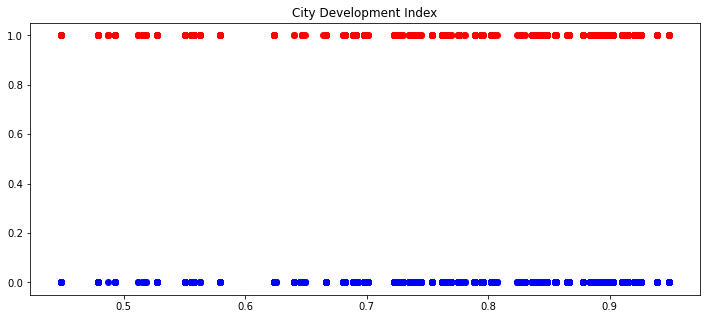

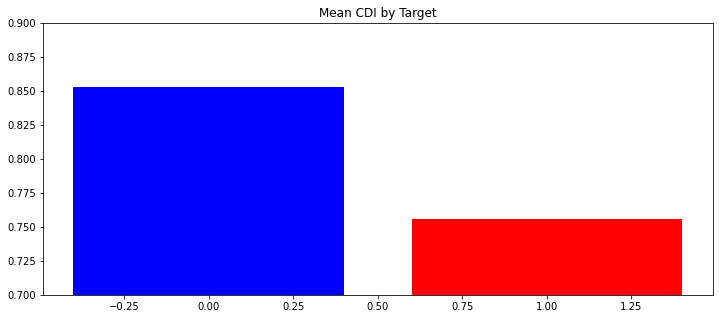

In [10]:
from numpy import mean

plt.figure(figsize = (12,5))
plt.title("City Development Index")
x1 = train[train['target'] == 0].loc[:,'city_development_index']
x2 = train[train['target'] == 1].loc[:,'city_development_index']
y1 = train[train['target'] == 0].loc[:,'target']
y2 = train[train['target'] == 1].loc[:,'target']
plt.scatter(x1, y1, color = 'b')
plt.scatter(x2, y2, color = 'r')
plt.show()

plt.figure(figsize = (12,5))
plt.title("Mean CDI by Target")
cdi_df = train.loc[:,['target','city_development_index']].groupby('target').agg({'city_development_index': 'mean'})
plt.bar(cdi_df.index, cdi_df['city_development_index'], color = ['b','r'])
plt.ylim(.7,.9)
plt.show()

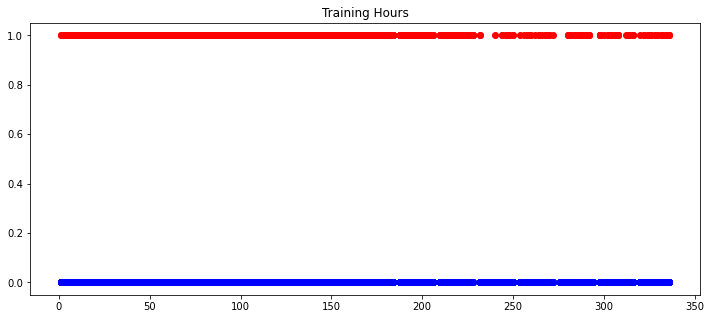

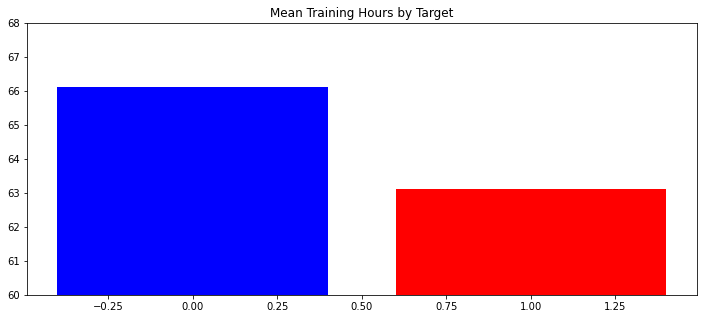

In [11]:
plt.figure(figsize = (12,5))
plt.title("Training Hours")
x1 = train[train['target'] == 0].loc[:,'training_hours']
x2 = train[train['target'] == 1].loc[:,'training_hours']
y1 = train[train['target'] == 0].loc[:,'target']
y2 = train[train['target'] == 1].loc[:,'target']
plt.scatter(x1, y1, color = 'b')
plt.scatter(x2, y2, color = 'r')
plt.show()

plt.figure(figsize = (12,5))
plt.title("Mean Training Hours by Target")
th_df = train.loc[:,['target','training_hours']].groupby('target').agg({'training_hours': 'mean'})
plt.bar(th_df.index, th_df['training_hours'], color = ['b','r'])
plt.ylim(60,68)
plt.show()

In [12]:
from scipy.stats import ttest_ind

cdi0 = train[train['target'] == 0].loc[:,'city_development_index']
cdi1 = train[train['target'] == 1].loc[:,'city_development_index']
cdi_ttest = ttest_ind(cdi0, cdi1)


th0 = train[train['target'] == 0].loc[:,'training_hours']
th1 = train[train['target'] == 1].loc[:,'training_hours']
th_ttest = ttest_ind(th0, th1)


print("t-test of CDI between target categories = %.3f with p-value = %.3f" % (cdi_ttest.statistic, cdi_ttest.pvalue))
print("t-test of training hours between target categories = %.3f with p-value = %.3f" % (th_ttest.statistic, th_ttest.pvalue))

t-test of CDI between target categories = 50.316 with p-value = 0.000
t-test of training hours between target categories = 2.987 with p-value = 0.003


It looks like CDI may be more related to the target variable than training hours is. Now that we've gotten to know our data a little bit, let's move on to preprocessing and model fitting.

# Data Preprocessing

We'll begin by preprocessing the data. We have a lot of missing values, which we'll deal with using a simple imputation procedure. It will also be helpful to convert categorical variables to sets of binary variables. Since there are so many cities, and we have a relevant continuous variable measuring a relevant aspect of one's city (city_development_index), we'll drop the feature for now. Training hours and city development index are also both on different scales. To rectify this, we'll rescale training hours to be between 0 and 1.

In [13]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import minmax_scale

X_train = train.drop(['enrollee_id', 'target', 'city'], axis = 1)
y_train = train['target']

imputer = SimpleImputer(strategy = 'most_frequent')

X_train_cols = X_train.columns
X_train = imputer.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns = X_train_cols)
X_train.training_hours = minmax_scale(X_train.training_hours)
X_train.city_development_index = X_train.city_development_index.astype('float64')
X_train = pd.get_dummies(X_train)
X_train_cols = X_train.columns
X_train

,city_development_index,training_hours,gender_Female,gender_Male,gender_Other,relevent_experience_Has relevent experience,relevent_experience_No relevent experience,enrolled_university_Full time course,enrolled_university_Part time course,enrolled_university_no_enrollment,...,company_type_NGO,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd,last_new_job_1,last_new_job_2,last_new_job_3,last_new_job_4,last_new_job_>4,last_new_job_never
0,0.920,0.104478,0,1,0,1,0,0,0,1,...,0,0,0,1,1,0,0,0,0,0
1,0.776,0.137313,0,1,0,0,1,0,0,1,...,0,0,0,1,0,0,0,0,1,0
2,0.624,0.244776,0,1,0,0,1,1,0,0,...,0,0,0,1,0,0,0,0,0,1
3,0.789,0.152239,0,1,0,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,1
4,0.767,0.020896,0,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19153,0.878,0.122388,0,1,0,0,1,0,0,1,...,0,0,0,1,1,0,0,0,0,0
19154,0.920,0.152239,0,1,0,1,0,0,0,1,...,0,0,0,1,0,0,0,1,0,0
19155,0.920,0.128358,0,1,0,1,0,0,0,1,...,0,0,0,1,0,0,0,1,0,0
19156,0.802,0.286567,0,1,0,1,0,0,0,1,...,0,0,0,1,0,1,0,0,0,0


# Model Fitting and Hyperparameter Tuning

Now we're ready to fit our model! We'll use a random forest model, as it is a great classifier for mixed data types. We can try to adjust the model for imbalanced classes using weighting.

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

rf = RandomForestClassifier(random_state = rng, class_weight = "balanced_subsample").fit(X_train, y_train)

crossval_acc = cross_val_score(rf, X_train, y_train, scoring = 'accuracy')
crossval_prec = cross_val_score(rf, X_train, y_train, scoring = 'precision')
crossval_rec = cross_val_score(rf, X_train, y_train, scoring = 'recall')
crossval_f1 = cross_val_score(rf, X_train, y_train, scoring = 'f1_macro')
crossval_auroc = cross_val_score(rf, X_train, y_train, scoring = 'roc_auc')

print("%.3f cross validated mean accuracy, with a std of %0.3f" % (crossval_acc.mean(), crossval_acc.std()))
print("%.3f cross validated mean precision, with a std of %0.3f" % (crossval_prec.mean(), crossval_prec.std()))
print("%.3f cross validated mean recall, with a std of %0.3f" % (crossval_rec.mean(), crossval_rec.std()))
print("%.3f cross validated mean F1 score, with a std of %0.3f" % (crossval_f1.mean(), crossval_f1.std()))
print("%.3f cross validated mean AUROC, with a std of %0.3f" % (crossval_auroc.mean(), crossval_auroc.std()))

0.764 cross validated mean accuracy, with a std of 0.009
0.540 cross validated mean precision, with a std of 0.026
0.357 cross validated mean recall, with a std of 0.022
0.641 cross validated mean F1 score, with a std of 0.014
0.747 cross validated mean AUROC, with a std of 0.004


This is a good start. However, our AUROC metric (which will be the final performance metric for the task) is a little on the low side at .75. Furthermore, looking at the precision and recall scores tells us the model tends to miss people who are actually seeking new jobs. In practice, it's likely that we are mostly interested in correctly identifying new job seekers, so the low mean recall is especially troubling.

We can try to improve the performance of the model by performing hyperparameter tuning. We'll try just a short list of values to see if the model improves. Since this can take a long time, the output from a previous run is shown with code commented out.

In [15]:
# from sklearn.model_selection import GridSearchCV

# search = {'max_features': ['auto', 'sqrt'],
#           'n_estimators': [100, 200],
#           'oob_score': [True, False]}

# rf_ht = GridSearchCV(rf, search, scoring = 'roc_auc').fit(X_train, y_train)

# print(rf_ht.best_estimator_)
# print(rf_ht.best_params_)

In [16]:
# RandomForestClassifier(class_weight='balanced_subsample', n_estimators=200,
#                        oob_score=True,
#                        random_state=RandomState(MT19937) at 0x7F0606FD3160)
# {'max_features': 'auto', 'n_estimators': 200, 'oob_score': True}

We'll fit a final model using these parameters and examine model performance.

In [17]:
rf_final = RandomForestClassifier(max_features = 'auto', n_estimators = 200, oob_score = True,
                                  random_state = rng, class_weight = "balanced_subsample").fit(X_train, y_train)

crossval_acc = cross_val_score(rf_final, X_train, y_train, scoring = 'accuracy')
crossval_prec = cross_val_score(rf_final, X_train, y_train, scoring = 'precision')
crossval_rec = cross_val_score(rf_final, X_train, y_train, scoring = 'recall')
crossval_f1 = cross_val_score(rf_final, X_train, y_train, scoring = 'f1_macro')
crossval_auroc = cross_val_score(rf_final, X_train, y_train, scoring = 'roc_auc')

print("%.3f cross validated mean accuracy, with a std of %0.3f" % (crossval_acc.mean(), crossval_acc.std()))
print("%.3f cross validated mean precision, with a std of %0.3f" % (crossval_prec.mean(), crossval_prec.std()))
print("%.3f cross validated mean recall, with a std of %0.3f" % (crossval_rec.mean(), crossval_rec.std()))
print("%.3f cross validated mean F1 score, with a std of %0.3f" % (crossval_f1.mean(), crossval_f1.std()))
print("%.3f cross validated mean AUROC, with a std of %0.3f" % (crossval_auroc.mean(), crossval_auroc.std()))

0.762 cross validated mean accuracy, with a std of 0.008
0.533 cross validated mean precision, with a std of 0.023
0.363 cross validated mean recall, with a std of 0.018
0.641 cross validated mean F1 score, with a std of 0.012
0.749 cross validated mean AUROC, with a std of 0.005


We see a slight increase to performance metrics by changing some of the parameters. In practice, we could search across many different values for each parameter and look at new parameters to adjust, but let's stick with these values for now.

# Feature Importance

To finish, we'll get a simple feature importance measure from the model:

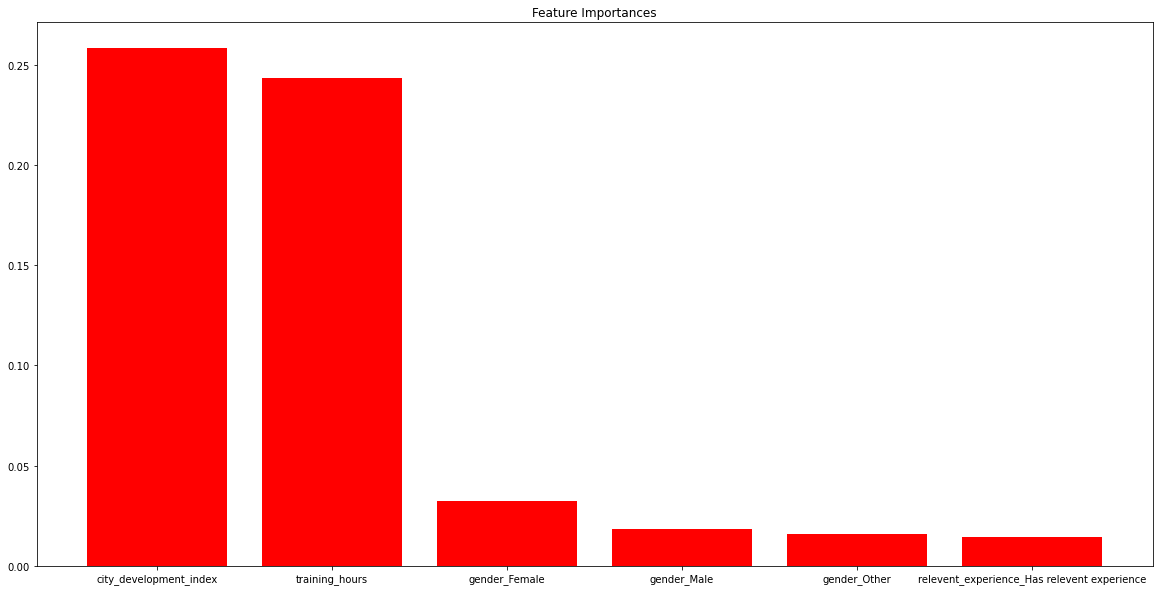

In [18]:
feat_imp = rf_final.feature_importances_
indices = np.argsort(feat_imp)[::-1]
feat_df = pd.DataFrame({'importances': feat_imp[indices],
                        'labels' : X_train_cols})
plt.figure(figsize = (20,10))
plt.title("Feature Importances")
plt.bar(feat_df.loc[0:5,'labels'], feat_df.loc[0:5,'importances'], color = 'r')
plt.show()

In [19]:
feat_df[0:25]

,importances,labels
0,0.258318,city_development_index
1,0.243549,training_hours
2,0.032567,gender_Female
3,0.018189,gender_Male
4,0.015740,gender_Other
5,0.014385,relevent_experience_Has relevent experience
6,0.013957,relevent_experience_No relevent experience
7,0.013358,enrolled_university_Full time course
8,0.012875,enrolled_university_Part time course
9,0.011996,enrolled_university_no_enrollment


It appears as though the city development index, followed by the number of training hours, are the variables the model heavily relied on to distinguish between non-job seekers from job seekers. However, the default feature importance metrics may be skewed toward numerical variables and/or high cardinality categorical features.


# Closing Remarks

To finish, we'll apply the sample preprocessing pipeline to the test data and generate our predicted classes, thus completing the assigned task. As with any machine learning model, this could be improved upon further by exploring other techniques not covered here, such as:

* Under/oversampling (e.g., SMOTE)
* Exploring other models (logistic regression, kNN, multilayer perceptron)
* More advanced missing data imputation (e.g., multivariate techniques, model-based techniques as with kNNImputer)
* Permutation-based feature importances 

...and much more!

In [20]:
X_test = test.drop(['enrollee_id', 'city'], axis = 1)
X_test_cols = X_test.columns
X_test = imputer.fit_transform(X_test)
X_test = pd.DataFrame(X_test, columns = X_test_cols)
X_test.training_hours = minmax_scale(X_test.training_hours)
X_test.city_development_index = X_test.city_development_index.astype('float64')
X_test = pd.get_dummies(X_test)
X_test_cols = X_test.columns
X_test

,city_development_index,training_hours,gender_Female,gender_Male,gender_Other,relevent_experience_Has relevent experience,relevent_experience_No relevent experience,enrolled_university_Full time course,enrolled_university_Part time course,enrolled_university_no_enrollment,...,company_type_NGO,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd,last_new_job_1,last_new_job_2,last_new_job_3,last_new_job_4,last_new_job_>4,last_new_job_never
0,0.827,0.060060,0,1,0,1,0,1,0,0,...,0,0,0,1,1,0,0,0,0,0
1,0.920,0.291291,1,0,0,1,0,0,0,1,...,0,0,0,1,1,0,0,0,0,0
2,0.624,0.042042,0,1,0,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,1
3,0.827,0.114114,0,1,0,1,0,0,0,1,...,0,0,0,1,1,0,0,0,0,0
4,0.920,0.213213,0,1,0,1,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2124,0.920,0.042042,0,1,0,0,1,0,0,1,...,0,0,1,0,0,0,0,1,0,0
2125,0.897,0.087087,0,1,0,1,0,0,0,1,...,0,0,0,1,0,1,0,0,0,0
2126,0.887,0.051051,0,1,0,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,1
2127,0.804,0.249249,0,1,0,1,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0


In [21]:
en_id = test['enrollee_id']
probs = rf.predict_proba(X_test)
probs = probs[:,1]
submission = pd.DataFrame({'enrollee_id' : en_id,
                         'target' : probs})
submission.to_csv("submission.csv")
submission

,enrollee_id,target
0,32403,0.070000
1,9858,0.490000
2,31806,0.280000
3,27385,0.070000
4,27724,0.007495
...,...,...
2124,1289,0.200000
2125,195,0.260000
2126,31762,0.020000
2127,7873,0.160000


# Contact Information

My name is Adrian Abellanoza, M.S. I am a Ph.D candidate in experimental psychology at the University of Texas at Arlington. In addition to being an academic researcher, I am an aspiring data scientist/analyst with previous internship experience in eCommerce, UX, and business intelligence. Feel free to contact me with questions, comments, or advice! I'd love to hear your input.

* LinkedIn: https://www.linkedin.com/in/aabellanoza/
* Email: a.abellanoz93@gmail.com
* GitHub: https://github.com/AAbellanoza